# Data Mining - What should the next Champion look like?

## Problemdefiniton
In League of Legends beeinflussen neue Champions die Spielbalance. Doch sind bestimmte Champion-Typen unterrepräsentiert? Diese Arbeit nutzt Machine Learning, um vorherzusagen, welche Champion-Eigenschaften im aktuellen Spielgewicht fehlen.

So wird sich die zentrale Frage gestellt: Welche Kombination von Champion-Eigenschaften ist im derzeitigen Spielökosystem am stärksten unterrepräsentiert und könnte als Grundlage für die Entwicklung eines neuen Champions dienen?

## Import - Datenauswahl

### Import notwendiger Bibliotheken


In [1]:
# Datenverarbeitung & Numerik
import pandas as pd  # Datenverarbeitung
import numpy as np  # Numerische Berechnungen

# Visualisierung
import matplotlib.pyplot as plt  # Basis-Visualisierung
import seaborn as sns  # Erweiterte Visualisierung
%matplotlib inline  

# Datenaufbereitung & Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  # Skalierung & Encoding
from sklearn.model_selection import train_test_split  # Aufteilung in Trainings- & Testdaten
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Modelle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest Modelle
from sklearn.linear_model import LogisticRegression, LinearRegression  # Lineare Modelle
from sklearn.svm import SVC  # Support Vector Machine Modell
from sklearn.neural_network import MLPRegressor  # Neuronales Netz für Regression
from xgboost import XGBClassifier, XGBRegressor  # Boosted Trees Modelle

# Modellbewertung
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Klassifikationsmetriken
from sklearn.metrics import r2_score, mean_squared_error  # Regressionsmetriken

# Hyperparameter-Tuning
from sklearn.model_selection import GridSearchCV

# Explorative Datenanalyse
from ydata_profiling import ProfileReport  # Automatische EDA

# Sonstiges
import itertools  # Kombinatorik
import pickle  # Modell speichern/laden

### Datenimport

Der folgende Datensatz wurde auf der Website "Kaggle" gefunden, hat seinen Ursprung jedoch in
der Analyse- und Datenplattform MetaSRC. Diese Plattform sammelt, aggregiert und analysiert Match-Daten
um die Trends des Spiels League of Legends darzustellen.
Die Daten werden direkt aus öffentlichen Riot Games-APIs bezogen, wodurch die Statistiken
patch-basiert aktualisiert werden.

In [2]:
# Datensatz laden
df = pd.read_csv('League of Legends Champion Stats 12.1.csv', sep=';')
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23


Der nächste Datensatz entstammt auch Kaggle, hat aber seinen Ursprung in dem "League of Legends Wiki Champion Data Module".
Da dieser Veröffentlichungsdaten beinhaltet, eignet sich dieser für Zeitreihenanalysen
Der Fokus liegt allerdings auf ersterem Datensatz, dieser dient nur als Hilfe für die Zeitreihenanalyse


In [3]:
df_basic = pd.read_csv('200125_LoL_champion_data.csv')
df_basic.head()

,Unnamed: 0,id,apiname,title,difficulty,herotype,alttype,resource,stats,rangetype,...,be,rp,skill_i,skill_q,skill_w,skill_e,skill_r,skills,fullname,nickname
0,Aatrox,266.0,Aatrox,the Darkin Blade,2,Fighter,Tank,Blood Well,"{'hp_base': 650, 'hp_lvl': 114, 'mp_base': 0, ...",Melee,...,4800,880,{1: 'Deathbringer Stance'},"{1: 'The Darkin Blade', 2: 'The Darkin Blade 3'}",{1: 'Infernal Chains'},{1: 'Umbral Dash'},{1: 'World Ender'},"{1: 'Deathbringer Stance', 2: 'The Darkin Blad...",NaN,NaN
1,Ahri,103.0,Ahri,the Nine-Tailed Fox,2,Mage,Assassin,Mana,"{'hp_base': 590, 'hp_lvl': 104, 'mp_base': 418...",Ranged,...,3150,790,{1: 'Essence Theft'},{1: 'Orb of Deception'},{1: 'Fox-Fire'},{1: 'Charm'},{1: 'Spirit Rush'},"{1: 'Essence Theft', 2: 'Orb of Deception', 3:...",NaN,NaN
2,Akali,84.0,Akali,the Rogue Assassin,2,Assassin,NaN,Energy,"{'hp_base': 600, 'hp_lvl': 119, 'mp_base': 200...",Melee,...,3150,790,"{1: ""Assassin's Mark""}",{1: 'Five Point Strike'},{1: 'Twilight Shroud'},{1: 'Shuriken Flip'},{1: 'Perfect Execution'},"{1: ""Assassin's Mark"", 2: 'Five Point Strike',...",Akali Jhomen Tethi,NaN
3,Akshan,166.0,Akshan,the Rogue Sentinel,3,Marksman,Assassin,Mana,"{'hp_base': 630, 'hp_lvl': 107, 'mp_base': 350...",Ranged,...,4800,880,{1: 'Dirty Fighting'},{1: 'Avengerang'},{1: 'Going Rogue'},{1: 'Heroic Swing'},{1: 'Comeuppance'},"{1: 'Dirty Fighting', 2: 'Avengerang', 3: 'Goi...",NaN,NaN
4,Alistar,12.0,Alistar,the Minotaur,1,Tank,Support,Mana,"{'hp_base': 685, 'hp_lvl': 120, 'mp_base': 350...",Melee,...,1350,585,{1: 'Triumphant Roar'},{1: 'Pulverize'},{1: 'Headbutt'},{1: 'Trample'},{1: 'Unbreakable Will'},"{1: 'Triumphant Roar', 2: 'Pulverize', 3: 'Hea...",NaN,NaN


### Merging

In [4]:
# Verbunden werden die Datensätze durch den gemeinsamen Schlüssel des Champion-Namens
# Dabei wollen wir zum ersten Datensatz die Informationen bezüglich Veröffenlichungsdatum hinzufügen

# Spaltennamen für Konsistenz anpassen
df_basic.rename(columns={'apiname': 'Name'}, inplace=True)

# 'date' Spalte in datetime umwandeln
df_basic['date'] = pd.to_datetime(df_basic['date'], errors='coerce')

# Füge die Veröffentlichungsdaten aus df_basic zum Haupt-Datensatz df hinzu
df = pd.merge(df, df_basic[['Name', 'date']], on='Name', how='left')

df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,date
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97,2013-06-13
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56,2011-12-14
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34,2010-05-11
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04,2010-05-11
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23,2021-07-22


## EDA und Preprocessing

Da dies ein Machine Learning Projekt ist, ist es wichtig, dass wir in den folgenden Abschnitten einen Überblick über die Daten erhalten und die Daten entsprechend vorbereiten.
Für die spätere Modellerstellung ist es dabei wichtig, dass Nullwerte entfernt werden, die Daten in numerische Werte umgewandelt werden und die Daten in Trainings- und Testdaten aufgeteilt werden.
Auch Skalierung der Daten ist wichtig, um sicherzustellen, dass die Modelle korrekt trainiert werden.
Der erste Schritt ist es, sich die Daten genauer anzuschauen, um zu sehen, welche Daten vorhanden sind und wie sie aussehen.

In [5]:
# Übersicht über die Daten
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    234 non-null    object        
 1   Class   233 non-null    object        
 2   Role    234 non-null    object        
 3   Tier    234 non-null    object        
 4   Score   234 non-null    float64       
 5   Trend   234 non-null    float64       
 6   Win %   234 non-null    object        
 7   Role %  234 non-null    object        
 8   Pick %  234 non-null    object        
 9   Ban %   234 non-null    object        
 10  KDA     234 non-null    float64       
 11  date    214 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 22.1+ KB


In [6]:
# Beschreibung der numerischen Spalten
# In Anbetracht der CRISP-DM-Vorgehensweise werden bedeutsame Kennzahlen wie Mittelwert, Median und
# Standardabweichung betrachtet

print(df.describe())

            Score       Trend         KDA                           date
count  234.000000  234.000000  234.000000                            214
mean    49.953675   -0.282991    2.332863  2012-08-29 08:17:56.635514112
min     11.030000  -20.170000    1.450000            2009-02-21 00:00:00
25%     38.935000   -3.480000    2.040000            2009-10-10 00:00:00
50%     46.560000   -0.815000    2.305000            2011-05-10 00:00:00
75%     59.100000    2.060000    2.547500            2013-12-13 00:00:00
max     94.230000   44.710000    4.110000            2021-09-23 00:00:00
std     16.473484    6.418863    0.414238                            NaN


### Zeitreihenanalyse

In [7]:
# Die Datumsspalte in numerische Werte umwandeln

# Veröffentlichungsdatum extrahieren
df['release_year'] = df['date'].dt.year

# Date spalte entfernen
df.drop('date', axis=1, inplace=True)

In [8]:
# Anzahl der veröffentlichten Champions pro Jahr berechnen
release_counts = df['release_year'].value_counts().sort_index()

In [9]:
# Veröffentlichung pro Rolle und Klasse analysieren
role_counts = df.groupby(['release_year', 'Role']).size().unstack()
class_counts = df.groupby(['release_year', 'Class']).size().unstack()

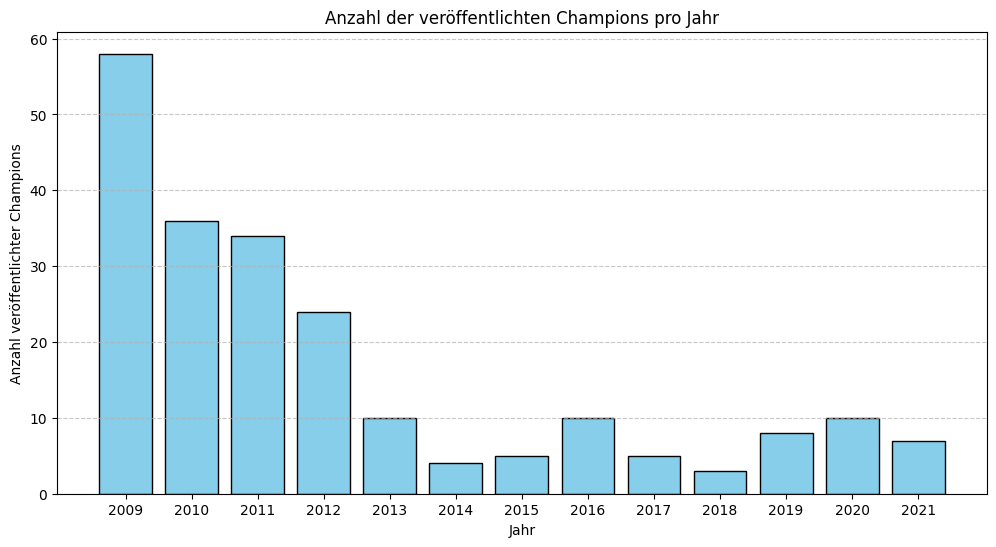

In [10]:
# Anzahl veröffentlichter Champions pro Jahr 
plt.figure(figsize=(12, 6))
plt.bar(release_counts.index, release_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Anzahl der veröffentlichten Champions pro Jahr")
plt.xticks(release_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preprocessing: In numerische Werte umwandeln

In [11]:
# Umwandlung von Prozentangaben in numerische Werte
percent_columns = ["Win %", "Role %", "Pick %", "Ban %"]
for col in percent_columns:
    df[col] = df[col].str.replace('%', '').astype(float)  # Prozent in Dezimalzahl umwandeln

print(df["Pick %"].describe())

numerical_features = ['Win %', 'Pick %', 'Ban %', 'Score', 'KDA', 'release_year']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

count    234.000000
mean       4.163077
std        4.089208
min        0.180000
25%        1.212500
50%        2.970000
75%        5.790000
max       24.550000
Name: Pick %, dtype: float64


### Betrachtung fehlender Werte

In [12]:
# Fehlende Werte
print(df.isnull().sum())

Name             0
Class            1
Role             0
Tier             0
Score            0
Trend            0
Win %            0
Role %           0
Pick %           0
Ban %            0
KDA              0
release_year    20
dtype: int64


In [13]:
missing_values = df.isnull().sum()

In [14]:
missing_percentage = (missing_values / len(df)) * 100

In [15]:
missing_df = pd.DataFrame({'Anzahl fehlender Werte': missing_values, 'Prozentueller Anteil': missing_percentage})
print(missing_df[missing_df['Anzahl fehlender Werte'] > 0])

              Anzahl fehlender Werte  Prozentueller Anteil
Class                              1              0.427350
release_year                      20              8.547009


In [16]:
# Alle Zeilen ausgeben, in denen das 'release_year' fehlt
missing_names_rows = df[df["release_year"].isnull()]  # Zeilen, in denen "Name" fehlt
print(missing_names_rows)


             Name     Class     Role Tier     Score  Trend     Win %  Role %  \
14   Aurelion Sol      Mage      MID    B -0.474727  -2.74  0.447362   91.23   
25       Cho'Gath      Tank      TOP    A  0.170719   2.64  1.644586   72.56   
26       Cho'Gath      Tank      MID    C -0.742395  -4.65 -0.291224   17.42   
31      Dr. Mundo  Marksman      TOP    S  0.777232  -2.08  1.013214   91.81   
64      Jarvan IV      Tank   JUNGLE    A  0.302120   4.21  0.584358   93.41   
71         Kai'Sa  Marksman      ADC  God  1.555295  10.50 -0.344831   97.77   
84        Kha'Zix  Assassin   JUNGLE    S  0.626364  -2.33  0.066156   98.88   
90        Kog'Maw  Marksman      ADC    B -0.617686  -2.80  1.626717   89.17   
91        LeBlanc  Assassin      MID    A  0.558838  -1.18 -0.720081   94.88   
92        Lee Sin   Fighter   JUNGLE  God  2.551143   0.28 -0.958334   96.61   
107     Master Yi  Assassin   JUNGLE    S  0.890382  -3.49 -0.189967   93.04   
108  Miss Fortune  Marksman      ADC    

In [17]:
mean_year = round(df["release_year"].mean())  # Aufrunden, da Jahre ganzzahlig sind
df["release_year"].fillna(mean_year, inplace=True)


In [18]:
print(df.isnull().sum())

Name            0
Class           1
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


In [19]:
# Die Zeile ausgeben, in welcher ein Wert für 'Class' fehlt
missing_names_rows = df[df["Class"].isnull()]  # Zeilen, in denen "Name" fehlt
print(missing_names_rows)

      Name Class Role Tier     Score  Trend     Win %  Role %    Pick %  \
95  Lillia   NaN  TOP    D -1.558176  -9.25 -0.511609   11.49 -0.922219   

       Ban %       KDA  release_year  
95 -0.624359 -0.902048      2.183163  


In [20]:
# den Champion 'Lillia' anzeigen
df[df['Name'] == 'Lillia']

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
94,Lillia,Fighter,JUNGLE,B,-0.452827,-1.69,-0.422264,85.39,-0.348754,-0.632140,0.791424,2.183163
95,Lillia,NaN,TOP,D,-1.558176,-9.25,-0.511609,11.49,-0.922219,-0.624359,-0.902048,2.183163


In [21]:
# Da ich weiss, dass Lillia Fighter ist, kann ich den Wert direkt einfügen
df.loc[df['Name'] == 'Lillia', 'Class'] = 'Fighter'

In [22]:
print(df.isnull().sum())

Name            0
Class           0
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


### Weitere EDA-Visualisierungen

<Figure size 1200x600 with 0 Axes>

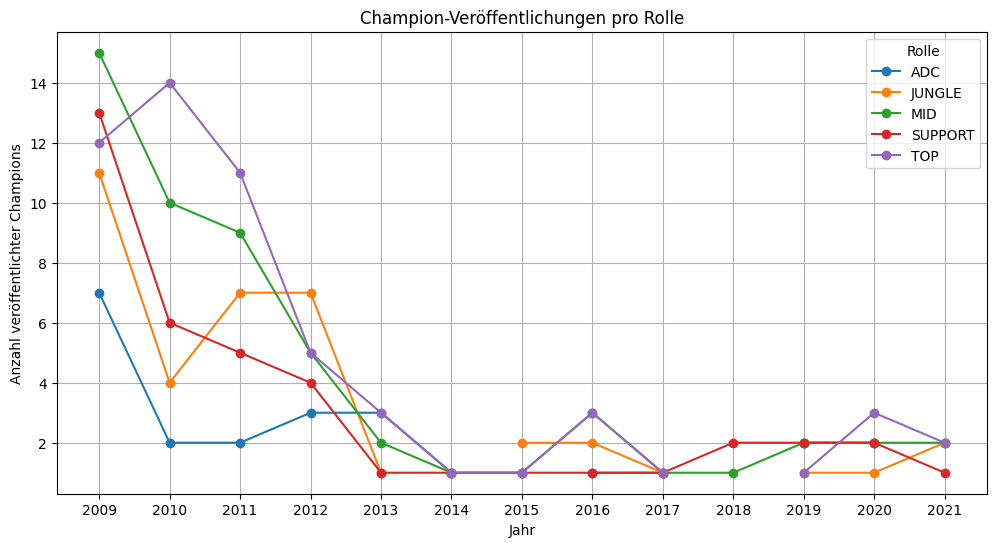

In [23]:
# Veröffentlichungen nach Rolle
plt.figure(figsize=(12, 6))
role_counts.plot(kind='line', marker='o', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Champion-Veröffentlichungen pro Rolle")
plt.xticks(release_counts.index)
plt.legend(title="Rolle")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

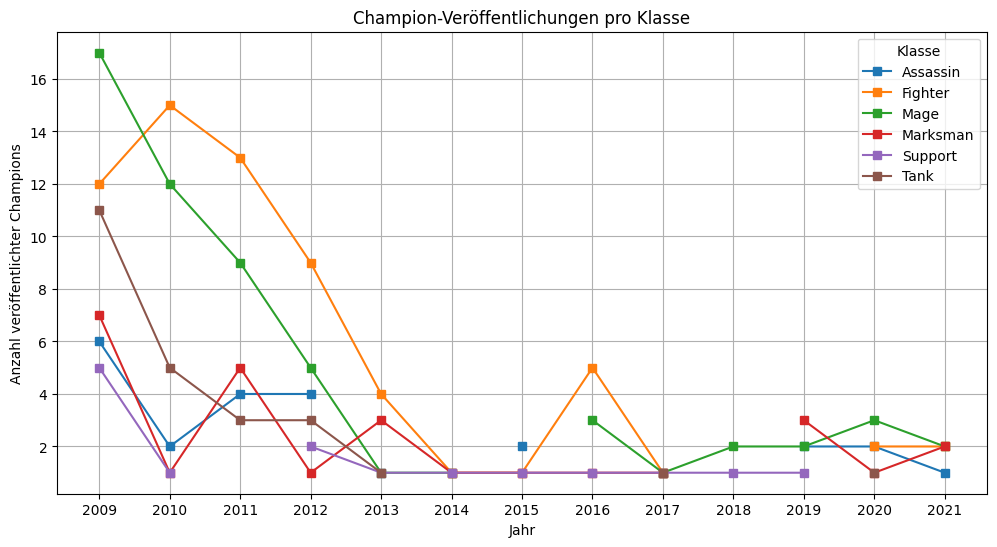

In [24]:
# Veröffentlichungen nach Klasse
plt.figure(figsize=(12, 6))
class_counts.plot(kind='line', marker='s', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Champion-Veröffentlichungen pro Klasse")
plt.xticks(release_counts.index)
plt.legend(title="Klasse")
plt.grid(True)
plt.show()

c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

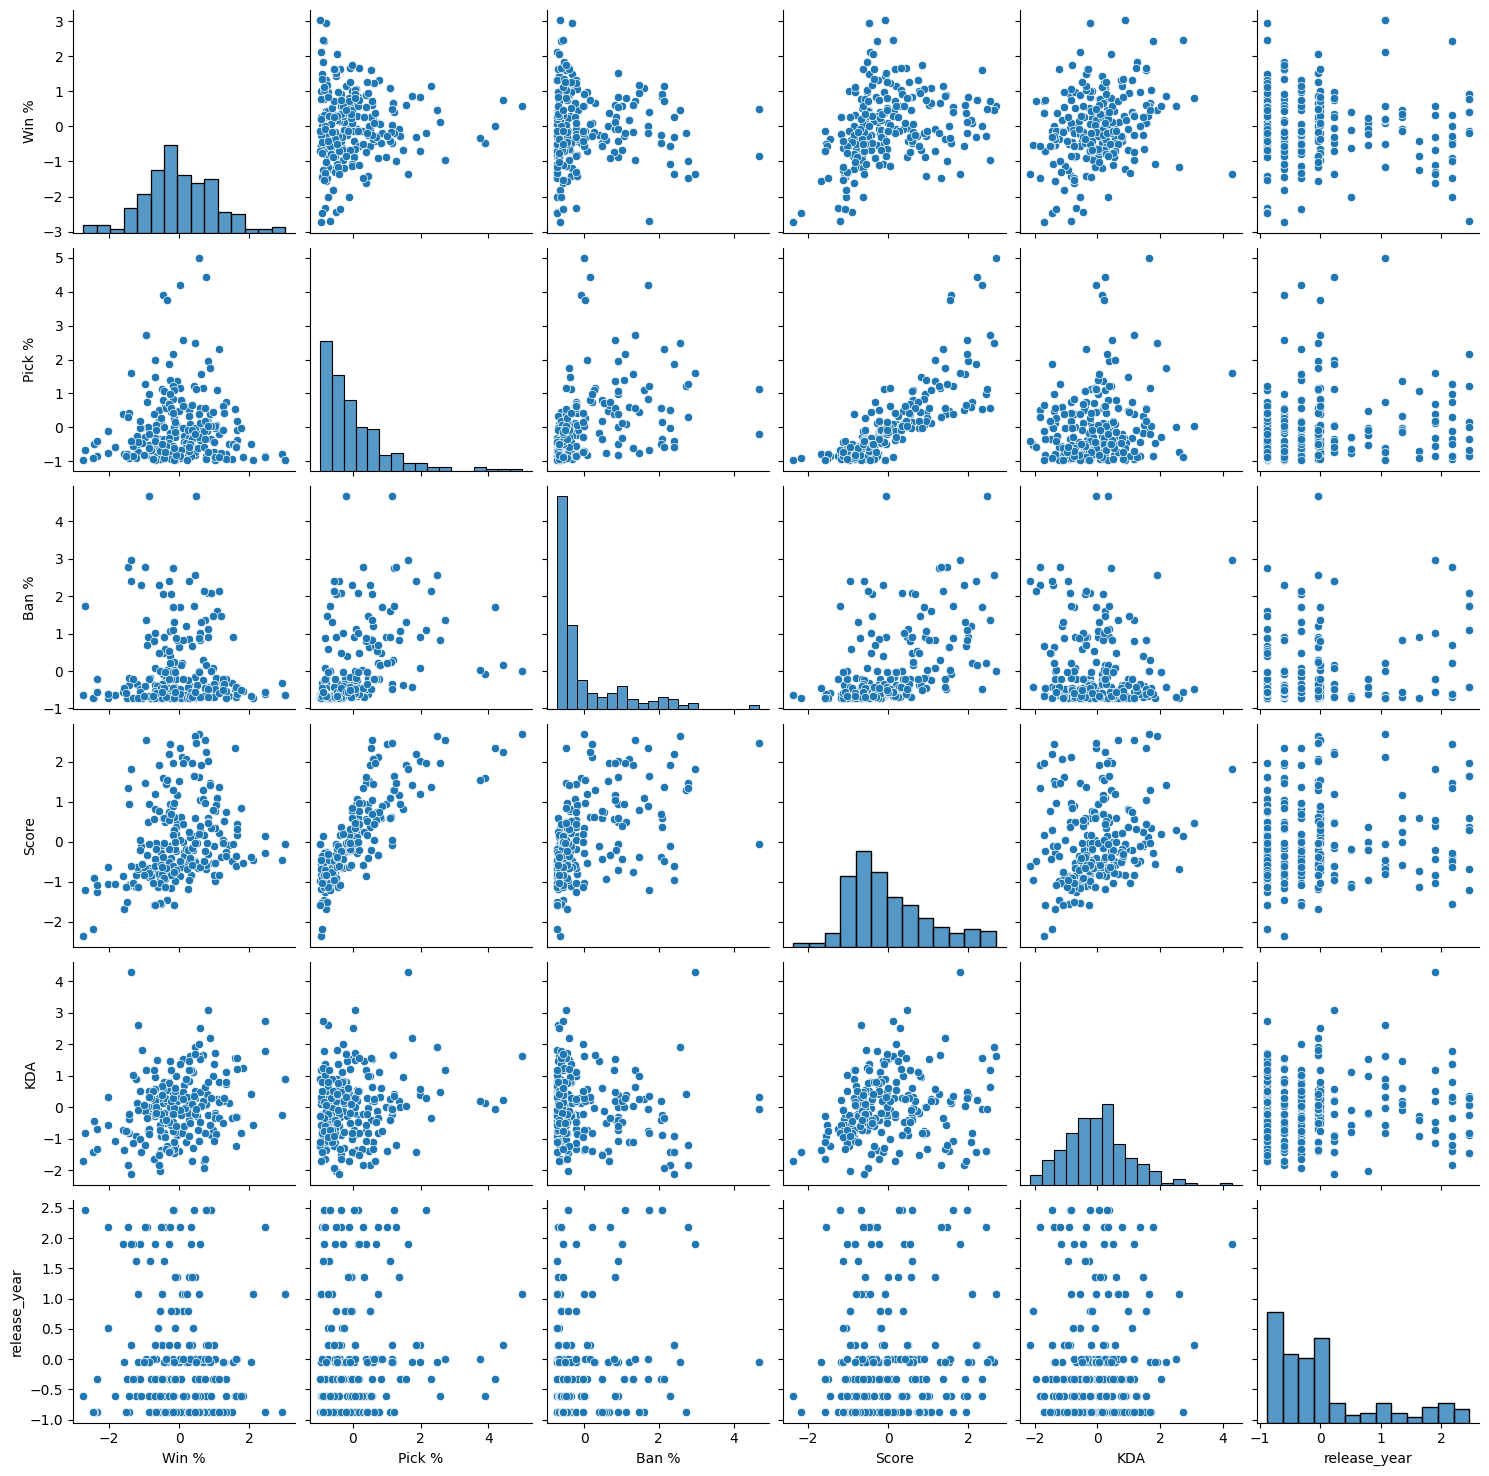

In [25]:
# Pairplot zur Visualisierung der Feature-Zusammenhänge
sns.pairplot(df[numerical_features])

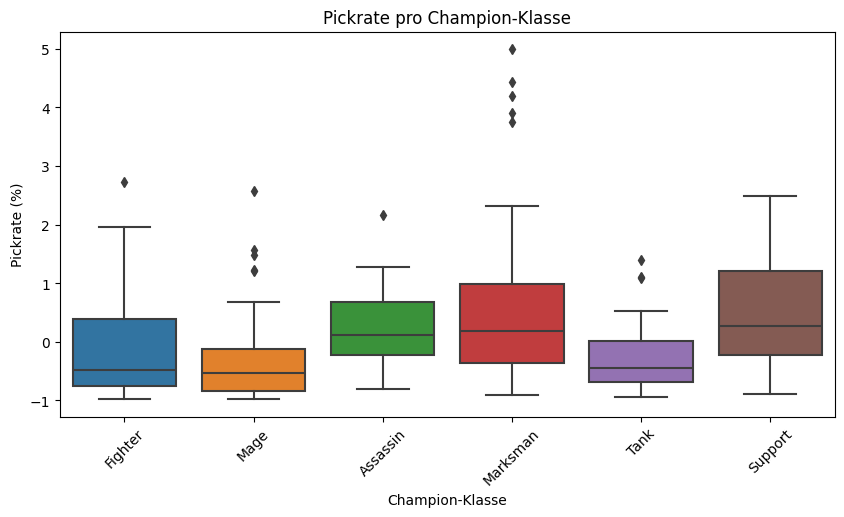

In [26]:
# Boxplot der Pickrate pro Klasse
plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Pick %', data=df)
plt.xlabel('Champion-Klasse')
plt.ylabel('Pickrate (%)')
plt.title('Pickrate pro Champion-Klasse')
plt.xticks(rotation=45)
plt.show()

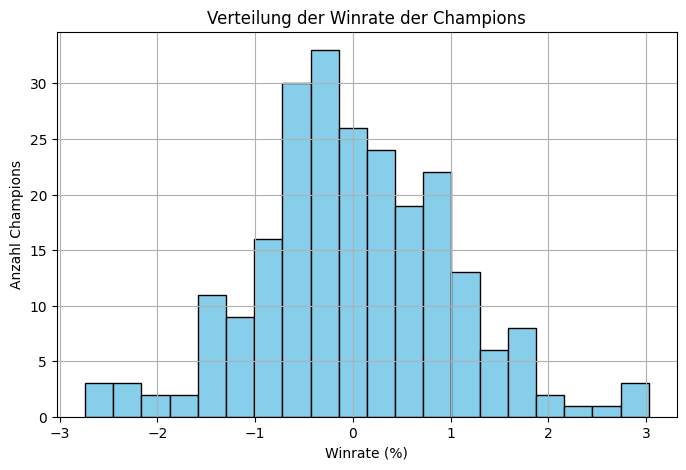

In [27]:
# Histogramm der Winrate
plt.figure(figsize=(8,5))
df['Win %'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Verteilung der Winrate der Champions')
plt.xlabel('Winrate (%)')
plt.ylabel('Anzahl Champions')
plt.show()

### Ydata Profiling Report erstellen

In [ ]:
# Für den ydata_profiling Report entfernen wir nicht float Datentypen wie 'Name'
df_profile_report = df.drop(['Name'], axis=1)

# Ydata Profiling Report erstellen
profile = ProfileReport(df, explorative=True)

# den Profile Report als HTML-Datei speichern
profile.to_file("ydata_profiling_report.html")

## Modellauswahl

Unser Modell soll vorhersagen, ob und wie Championeigenschaften wie deren Rolle zu einer Unterrepräsentation beitragen. Dazu werden mehrere Machnine Learning Modelle trainiert und anschließend verglichen. Die Modelle sind: Random Forest, Logistic Regression, Support Vector Machine und XGBoost.

### Feature Auswahl und Test-Train-Split

Zuerst wird die Zielvariable (Pick %) von den Features getrennt, und die Daten werden im Verhältnis 80:20 in Trainings- und Testsets aufgeteilt. Zudem wird die Spalte "Name" entfernt, da sie für das Modell nicht einfach in Kategorien oder numerische Werte umgewandelt werden kann.

In [28]:
df.drop(columns=["Name"], inplace=True, errors="ignore")

In [29]:
# Features und Zielvariable definieren
X = df.drop(columns=["Pick %"])  # Entferne Textspalten
y = df["Pick %"]

In [30]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.head()

,Class,Role,Tier,Score,Trend,Win %,Role %,Ban %,KDA,release_year
117,Assassin,JUNGLE,B,-0.623161,-6.54,-1.196588,86.82,-0.335144,0.138228,-0.324155
155,Assassin,JUNGLE,S,0.788790,3.87,0.953651,82.67,1.470176,1.009157,-0.881336
148,Tank,TOP,D,-1.173098,-2.66,0.262715,13.18,-0.711253,0.234998,-0.045564
158,Fighter,JUNGLE,C,-0.856763,-5.10,-0.797513,82.59,-0.722925,0.283383,-0.324155
231,Support,SUPPORT,A,-0.031249,1.68,0.459275,81.95,-0.573779,1.686546,-0.881336


In [32]:
y_train.head()

117   -0.255627
155    0.445274
148   -0.941824
158   -0.655092
231   -0.191909
Name: Pick %, dtype: float64

### Preprocessing 2


Hier werden numerische Features mit StandardScaler skaliert und kategorische Variablen mit Ordinal-Encoding umgewandelt. Außerdem kombiniert eine Pipeline das Preprocessing mit einem RandomForest-Regressor.

In [33]:
# Identifikation numerischer und kategorischer Features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing Pipeline mit OrdinalEncoder (numerische Kodierung von Kategorien)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)  
])

# Modell für Hyperparameter-Tuning (RandomForest)
rf = RandomForestRegressor(random_state=42)

# Pipeline mit Modell
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf)
])

### Modelltestung

Nun werden die Modelle getestet, um zu sehen, welches Modell am besten performt.

In [34]:
# Modelle
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [35]:
# Training und Evaluation der Modelle
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {"R² Score": r2, "RMSE": rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}\n")

Training Linear Regression...
Linear Regression: R² = 0.7753, RMSE = 0.4965

Training Random Forest...
Random Forest: R² = 0.9481, RMSE = 0.2386

Training XGBoost...
XGBoost: R² = 0.9640, RMSE = 0.1986

Training Neural Network...
Neural Network: R² = 0.9530, RMSE = 0.2270



In [36]:
# Ergebnisse als DataFrame anzeigen
results_df = pd.DataFrame(results).T
print("Modellvergleich:")
print(results_df)
# Bestes Modell bestimmen
best_model = results_df["R² Score"].idxmax()
print(f"\nBestes Modell: {best_model}")

Modellvergleich:
                   R² Score      RMSE
Linear Regression  0.775318  0.496502
Random Forest      0.948099  0.238631
XGBoost            0.964037  0.198639
Neural Network     0.953050  0.226964

Bestes Modell: XGBoost


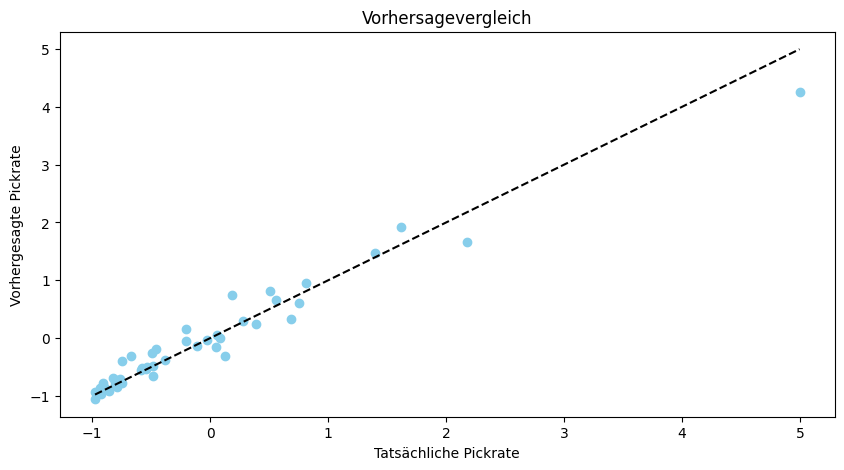

In [37]:
# Visualisierung der Vorhersagen
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black')
plt.xlabel('Tatsächliche Pickrate')
plt.ylabel('Vorhergesagte Pickrate')
plt.title('Vorhersagevergleich')
plt.show()

### Preprocessing 2

Hier werden numerische Features mit StandardScaler skaliert und kategorische Variablen mit Ordinal-Encoding umgewandelt. Außerdem kombiniert eine Pipeline das Preprocessing.

In [38]:
# Identifikation numerischer und kategorischer Features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

In [39]:
# Preprocessing Pipeline mit OrdinalEncoder (numerische Kodierung von Kategorien)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)  
])

In [40]:
# Modell für Hyperparameter-Tuning (XGBoost)
xgb = XGBRegressor(random_state=42)

In [41]:
# Pipeline mit Preprocessing und Modell
pipeline = Pipeline([
    ("preprocessor", preprocessor),  
    ("model", xgb)
])

## Hyperparameter Tuning

Nun wird mittels GridSearchCV Hyperparameter Tuning durchgeführt.

In [42]:
# Definition der Suchräume für die Hyperparameter
param_grid_xgb = {
    "model__n_estimators": [50, 100, 200],  # Anzahl der Bäume
    "model__max_depth": [3, 5, 7, 10],  # Maximale Tiefe der Bäume
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],  # Lernrate
    "model__subsample": [0.6, 0.8, 1.0],  # Anteil der Daten für jedes Boosting
    "model__colsample_bytree": [0.6, 0.8, 1.0],  # Anteil der Features für jeden Baum
    "model__gamma": [0, 0.1, 0.2, 0.5],  # Regularisierung
    "model__reg_alpha": [0, 0.01, 0.1, 1],  # L1-Regularisierung
    "model__reg_lambda": [0.1, 1, 10]  # L2-Regularisierung
}

Nun wird das Tuning durchgeführt. Dies wird etwas größere Zeitspanne in Anspruch nehmen, da 8 Hyperparameter mit einer Fülle an Werten getestet werden.

In [43]:
# GridSearchCV für die Optimierung
xgb_cv = GridSearchCV(pipeline, param_grid_xgb, cv=5, scoring="r2", n_jobs=-1, verbose=2)


# Modelltraining mit Hyperparameter-Tuning
xgb_cv.fit(X_train, y_train)

# Beste Parameter und Score ausgeben
best_params_xgb = xgb_cv.best_params_
best_score_xgb = xgb_cv.best_score_

best_params_xgb, best_score_xgb

Fitting 5 folds for each of 20736 candidates, totalling 103680 fits


({'model__colsample_bytree': 0.8,
  'model__gamma': 0,
  'model__learning_rate': 0.2,
  'model__max_depth': 3,
  'model__n_estimators': 200,
  'model__reg_alpha': 0.01,
  'model__reg_lambda': 0.1,
  'model__subsample': 1.0},
 0.9277928463633069)

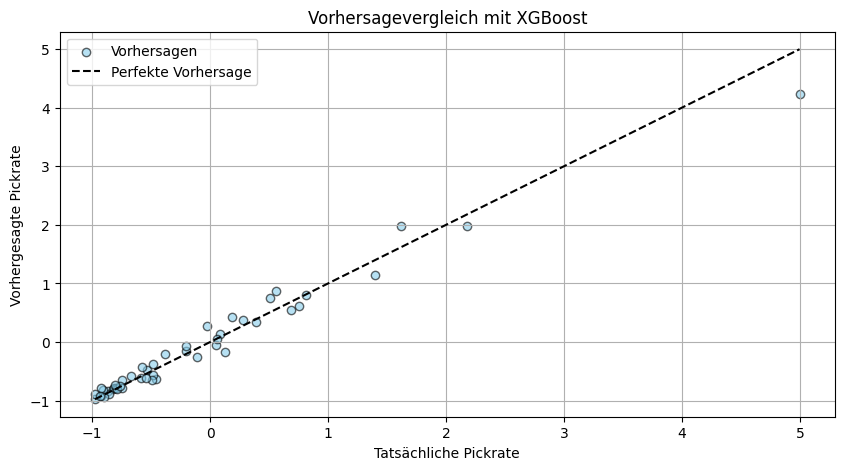

In [44]:
# Beste XGBoost-Pipeline nach GridSearchCV abrufen
best_xgb_model = xgb_cv.best_estimator_

# Vorhersagen auf dem Testset machen
y_pred_xgb = best_xgb_model.predict(X_test)

# Scatterplot: Tatsächliche vs. vorhergesagte Pickrate
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_xgb, color='skyblue', alpha=0.6, edgecolors='k', label="Vorhersagen")

# Linie für perfekte Vorhersage (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black', label="Perfekte Vorhersage")

# Achsenbeschriftung & Titel
plt.xlabel('Tatsächliche Pickrate')
plt.ylabel('Vorhergesagte Pickrate')
plt.title('Vorhersagevergleich mit XGBoost')
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()


In [45]:
# Bestes Modell speichern
with open("lol_pickrate_model.pkl", "wb") as file:
    pickle.dump(xgb_cv, file) 